Практика. Часть 3

DQN для задачи CartPole


In [16]:
import time
import random
import numpy as np

import gym

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

import matplotlib.pyplot as plt
%matplotlib inline
print(tf.__version__)

2.16.2


In [17]:
env = gym.make('CartPole-v0')

STATE_LIMITS = env.observation_space
NUM_ACTIONS = env.action_space.n

print('Actions: {}'.format(NUM_ACTIONS))
print('States limits:')
for i in range(STATE_LIMITS.shape[0]):
    print('[{}, {}]'.format(STATE_LIMITS.low[i], STATE_LIMITS.high[i]))

Actions: 2
States limits:
[-4.800000190734863, 4.800000190734863]
[-3.4028234663852886e+38, 3.4028234663852886e+38]
[-0.41887903213500977, 0.41887903213500977]
[-3.4028234663852886e+38, 3.4028234663852886e+38]


/Users/apple/python/SkillFactory/Ml_learning/venv/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [18]:
LR = 0.001
gamma = 0.95

NUM_EPISODES = 2000
MAX_STEPS = 200
REWARD_AVERAGE_WINDOW = 20

In [19]:
model = M.Sequential([
    L.Dense(24, activation='relu'),
    L.Dense(24, activation='relu'),
    L.Dense(NUM_ACTIONS, activation=None, use_bias=False),
])

def evalQ(s):
    return model(s[None, ...].astype(np.float32)).numpy()[0]

In [20]:
#def loss(q1, q2):
#    return tf.reduce_sum(tf.square(q1 - q2))

optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
model.compile(loss='mse', optimizer=optimizer)

pathLenList = []
totalRewardList = []
totalRewardAverageList = []

In [23]:
for i in range(NUM_EPISODES):
    
    eps = 1. / ((i / 50) + 10)
    
    s, _ = env.reset()
    s = np.array([s], dtype=np.float32)  # Преобразуем в массив с размерностью (1, NUM_STATES)

    totalReward = 0
    step = 0
    
    while step < MAX_STEPS:
        step += 1

        Q_s = evalQ(s)  # Получаем Q-значения для состояния s

        if np.random.rand() < eps:
            a = env.action_space.sample()
        else:
            a = np.argmax(Q_s)

        s1, r, done, _, _ = env.step(a)  # Получаем следующее состояние s1
        s1 = np.array([s1], dtype=np.float32)  # Преобразуем s1 в правильный формат

        Q_s1 = evalQ(s1)  # Получаем Q-значения для s1
        
        Q_target = Q_s.copy()  # Создаем копию Q_s для корректного обновления
        if done:
            Q_target[0, a] = r  # Если эпизод завершен, присваиваем r
        else:
            Q_target[0, a] = r + gamma * np.max(Q_s1)  # Иначе рассчитываем целевое значение

        # Обучаем модель с использованием тренировки на пакете
        # Используем reshape для обеспечения правильной размерности
        model.train_on_batch(s, Q_target)  # Передаем состояние и целевое значение

        totalReward += r
        s = s1  # Обновляем состояние
        
        if done:
            break
            
    pathLenList.append(step)
    totalRewardList.append(totalReward)

    if i % REWARD_AVERAGE_WINDOW == 0 and i >= REWARD_AVERAGE_WINDOW:
        totalRewardAverage = np.mean(totalRewardList[-REWARD_AVERAGE_WINDOW:])
        totalRewardAverageList.append(totalRewardAverage)
        if i % 100 == 0:
            print(f'Episode {i}: average total reward = {totalRewardAverage}')


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(1, 4), dtype=float32). Expected shape (1, 1, 4), but input has incompatible shape (1, 4)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 4), dtype=float32)
  • training=True
  • mask=None

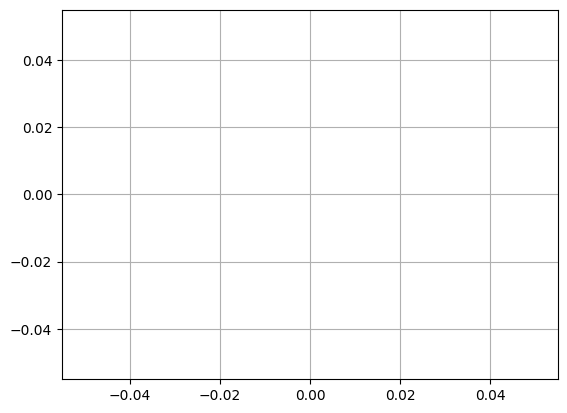

In [ ]:
plt.plot(pathLenList)
plt.grid()

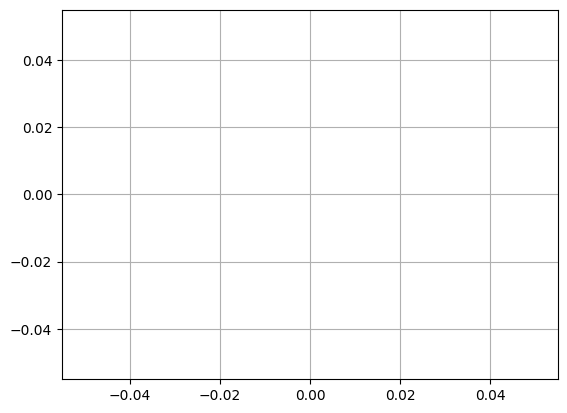

In [ ]:
plt.plot(totalRewardAverageList)
plt.grid()

In [ ]:
RECORD_VIDEO = True

if RECORD_VIDEO:
  
    !pip install pyvirtualdisplay > /dev/null 2>&1
    !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(1400, 900))
    display.start()

FileNotFoundError: [Errno 2] No such file or directory: 'Xvfb'

In [ ]:
USE_Q = True

if RECORD_VIDEO:
    from gym.wrappers import Monitor
    env_sim = Monitor(env, './video', force=True)
else:
    env_sim = env
    
s = env_sim.reset()
totalReward = 0

for _ in range(1000):
    env_sim.render()
    if USE_Q:
        a = np.argmax(evalQ(s))
    else:
        a = env_sim.action_space.sample()    
    s, r, done, _ = env_sim.step(a)
    totalReward += r
    if done:
        break
       
    if not RECORD_VIDEO:
        time.sleep(1./30)
        
env_sim.close()

print('Total reward = {}'.format(totalReward))

ImportError: cannot import name 'Monitor' from 'gym.wrappers' (/Users/apple/python/SkillFactory/Ml_learning/venv/lib/python3.10/site-packages/gym/wrappers/__init__.py)

In [ ]:
def show_video():
    import glob
    import io
    import base64
    from IPython.display import HTML
    from IPython import display as ipythondisplay

    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
            loop controls style="height: 400px;">
            <source src="data:video/mp4;base64,{0}" type="video/mp4" />
            </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    
show_video()

Could not find video


In [25]:
import time
import random
import numpy as np

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

import gym

import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
env = gym.make('Pong-v3')

STATE_SHAPE = env.observation_space.shape
NUM_ACTIONS = env.action_space.n

print('Actions: {}'.format(NUM_ACTIONS))
print('States shape: {}'.format(STATE_SHAPE))

NameNotFound: Environment Pong doesn't exist. 

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

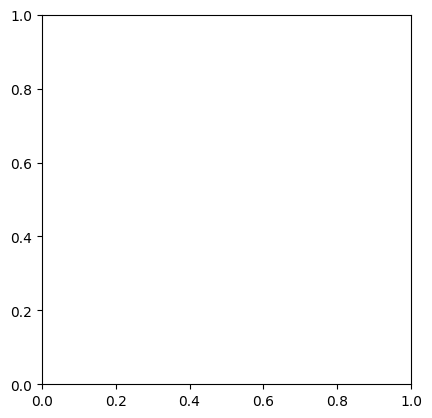

In [29]:
s = env.reset()
_=plt.imshow(s)

In [30]:
RECORD_VIDEO = True

if RECORD_VIDEO:
    !apt-get install python-opengl -y
    !apt install xvfb -y
    !pip install pyvirtualdisplay
    !pip install piglet

    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(1400, 900))
    display.start()

zsh:1: command not found: apt-get
zsh:1: command not found: apt

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
  Using cached attrs-25.1.0-py3-none-any.whl.metadata (10 kB)
Using cached attrs-25.1.0-py3-none-any.whl (63 kB)

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


FileNotFoundError: [Errno 2] No such file or directory: 'Xvfb'

In [31]:
if RECORD_VIDEO:
    from gym.wrappers.record_video import RecordVideo
    env_sim = RecordVideo(env, './video',  episode_trigger = lambda episode_number: True)
else:
    env_sim = env

s = env_sim.reset()
totalReward = 0

for _ in range(1000):
    env_sim.render()
    a = env_sim.action_space.sample() # Change to your policy (DQN)
    s, r, done, _ = env_sim.step(a)
    totalReward += r
    if done:
        break

    if not RECORD_VIDEO:
        time.sleep(1./30)

env_sim.close()

print('Total reward = {}'.format(totalReward))

DependencyNotInstalled: MoviePy is not installed, run `pip install moviepy`

In [32]:
def show_video():
    import glob
    import io
    import base64
    from IPython.display import HTML
    from IPython import display as ipythondisplay

    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
            loop controls style="height: 400px;">
            <source src="data:video/mp4;base64,{0}" type="video/mp4" />
            </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

show_video()

Could not find video
